In [1]:
# Let's import some of the common libraries
import pandas as pd
import numpy as np
import plotnine as p9

# ... and update a few of the default settings
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 40)

p9.options.set_option('dpi', 150)
#p9.options.set_option('figure_size', (8, 6))

plots_folder = './plots'

In [2]:
# Let's load the data
df = pd.read_csv('data/hotel_bookings.csv')
df.glimpse_unique(isna=True)


DataFrame with 119390 rows and 32 columns.
Column                          Dtype    Null         Unique values                                                     
------                          -----    ----         -------------                                                     
hotel                           object   0 null       'Resort Hotel', 'City Hotel'                                      
is_canceled                     int64    0 null       0, 1                                                              
lead_time                       int64    0 null       342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72, ...
arrival_date_year               int64    0 null       2015, 2016, 2017                                                  
arrival_date_month              object   0 null       'July', 'August', 'September', 'October', 'November', 'Decembe ...
arrival_date_week_number        int64    0 null       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

## Questions / Thoughts

### to answer:
* What is the ratio of cancelled / non-cancelled?
    *  What (if any) is the difference between 'is_cancelled' and 'reservations_status' == 'Canceled'?
* What is the capacity of the hotel?
* If we want to predict, which columns are 'unfair' (contains information that is not available at prediction time). E.g. reservation_status, reservation_status_date, (maybe) total_of_special_requests ?
* How is 'adr' = 0.0 ?
* Could typical vacation slots be an indicator?
* When people cancel, how long before check in do they cancel?
* Is there a way to know about the wait list drop outs?
### to fix:
* 'agent' and 'company' are id's -> they probably should not be floats.
* Why are 'children' are float? (Can't be fixed because of Pandas and Nan-values interaction...)
* Convert 'is_canceled', 'is_repeated_guest' to boolean
* Why are months a string ....?
### assumptions?
* If we want to capacity and pricing, then we need to make some assumptions on how pricing affects number of bookings.
    * Maybe we can use the waitlist to assume the price can be higher? (Probably not, as we don't know when people cancel their bookings if they are still on the waitlist..)
* Maybe its better to ignore pricing, and simply focus on optimizing capacity? <-- lets do that
### goal:
* Optimize profits by ensuring operating as close to full capacity as possible (with as few over-bookings as possible).
* Solution: Use estimated cancellations probabilities to overbook hotel.
    * Note: We assume a 3-to-1 rebooking to profit ratio. I.e. it is three times as expensive to re-booking guest to a competing hotel compared to the profit that guest would have generated.

## Data Engineering

In [3]:
# Lets fix a few of the columns
df['agent'] = df['agent'].where(df['agent'].isna(), df['agent'].astype('Int64').astype(str))
df['company'] = df['company'].where(df['company'].isna(), df['company'].astype('Int64').astype(str))
df['is_canceled'] = df['is_canceled'].astype('category')
df['is_repeated_guest'] = df['is_repeated_guest'].astype('category')
#df['is_canceled'] = df['is_canceled'].where(df['is_canceled'].isna(), df['is_canceled'].astype(bool))
#df['is_repeated_guest'] = df['is_repeated_guest'].where(df['is_repeated_guest'].isna(), df['is_repeated_guest'].astype(bool))

df.glimpse_unique(isna=True)

DataFrame with 119390 rows and 32 columns.
Column                          Dtype     Null         Unique values                                                    
------                          -----     ----         -------------                                                    
hotel                           object    0 null       'Resort Hotel', 'City Hotel'                                     
is_canceled                     category  0 null       0, 1                                                             
lead_time                       int64     0 null       342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72 ...
arrival_date_year               int64     0 null       2015, 2016, 2017                                                 
arrival_date_month              object    0 null       'July', 'August', 'September', 'October', 'November', 'Decemb ...
arrival_date_week_number        int64     0 null       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,

In [4]:
import calendar
month_dict = {month: index for index, month in enumerate(calendar.month_name) if month}
print(month_dict)

df['arrival_date_month_name'] = df['arrival_date_month']
df.replace({'arrival_date_month': month_dict}, inplace=True)

df.glimpse_unique(isna=True)

{'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
DataFrame with 119390 rows and 33 columns.
Column                          Dtype     Null         Unique values                                                    
------                          -----     ----         -------------                                                    
hotel                           object    0 null       'Resort Hotel', 'City Hotel'                                     
is_canceled                     category  0 null       0, 1                                                             
lead_time                       int64     0 null       342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72 ...
arrival_date_year               int64     0 null       2015, 2016, 2017                                                 
arrival_date_month              int64     0 null       7, 8, 9, 10, 1

### Data Exploration
* What is the ratio of cancelled / non-cancelled?
    * What (if any) is the difference between ‘is_cancelled’ and ‘reservations_status’ == ‘Canceled’?
* What is the capacity of the hotel?
* If we want to predict, which columns are ‘unfair’ (contains information that is not available at prediction time). E.g. reservation_status, reservation_status_date, (maybe) total_of_special_requests ?
* How is ‘adr’ = 0.0 ?
* Could typical vacation slots be an indicator?
* When people cancel, how long before check in do they cancel?
* Is there a way to know about the wait list drop outs?

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/distribution_of_reservation_status.png


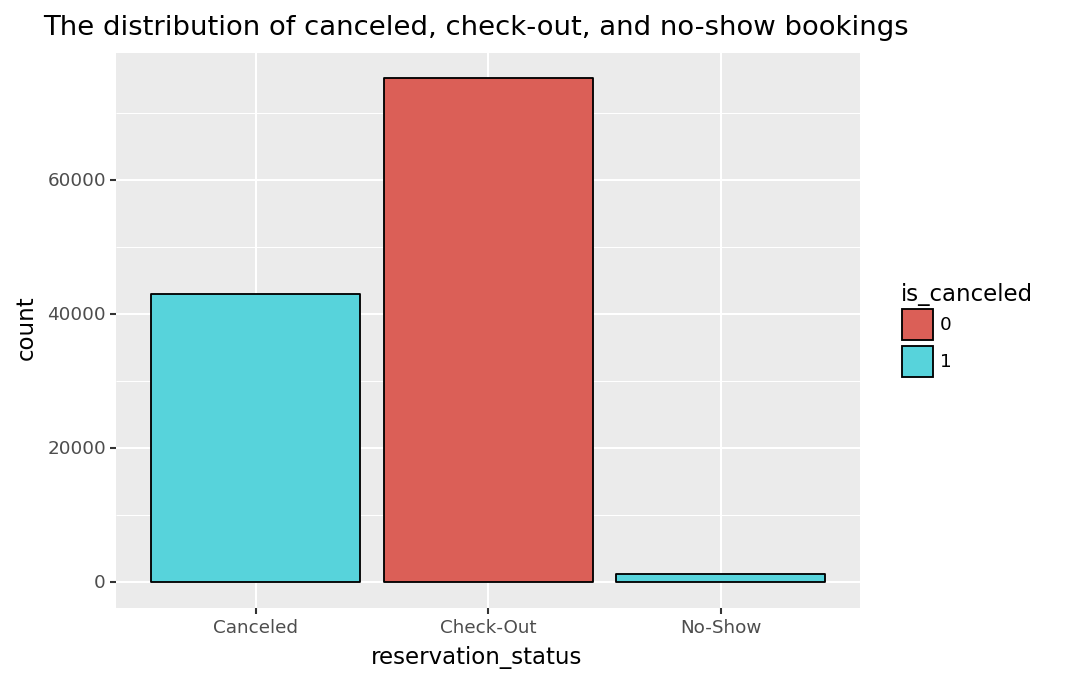

<ggplot: (359045514)>

In [5]:
# Lets start plotting
from plotnine import ggplot, aes
from plotnine import ggtitle, facet_wrap
from plotnine import theme, element_text, xlim, scale_y_log10
from plotnine import geom_point, geom_histogram, geom_density, geom_bar, geom_col


p = (
    ggplot(df, aes('reservation_status')) +
    geom_bar(aes(fill='is_canceled'), color='black') +
    ggtitle('The distribution of canceled, check-out, and no-show bookings')
)
p.save(f'{plots_folder}/distribution_of_reservation_status.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/distribution_of_hotels.png


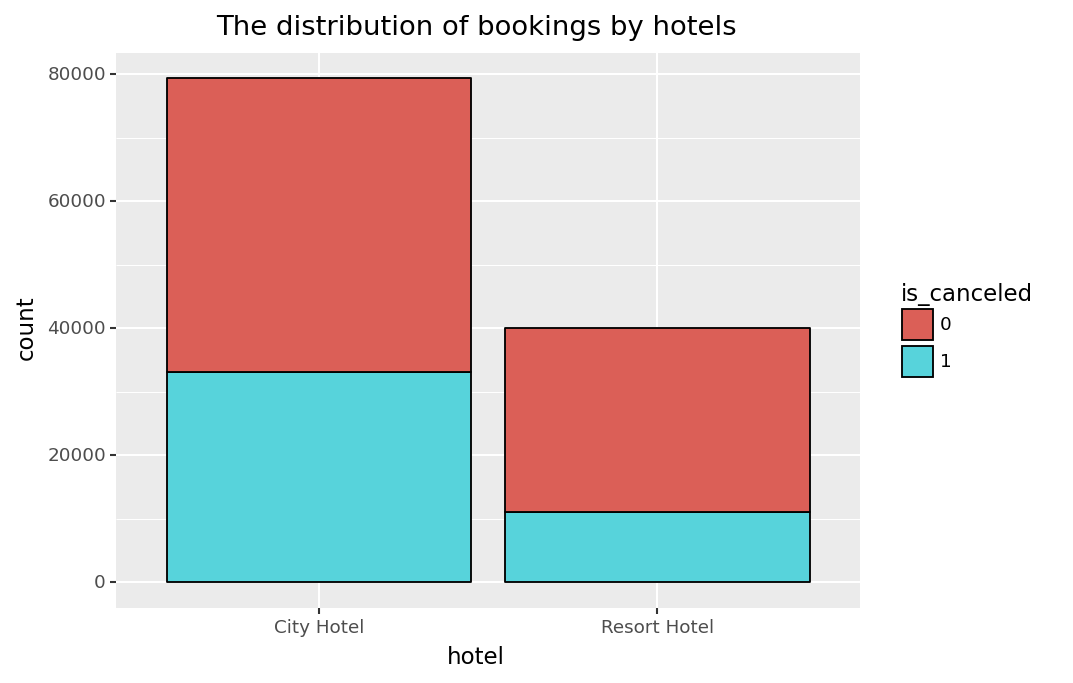

<ggplot: (358701459)>

In [6]:
p = (
    ggplot(df, aes('hotel')) +
    geom_bar(aes(fill='is_canceled'), color='black') +
    ggtitle('The distribution of bookings by hotels')
)
p.save(f'{plots_folder}/distribution_of_hotels.png', dpi=450, width=8, height=6)
p

In [7]:
# Let's have a look at when people cancel.
from siuba import _, select, mutate, group_by, ungroup, filter, summarize, rename, case_when
from siuba.siu import call

df = (
    df >>
    mutate(arrival_date = _.arrival_date_year.astype(str)
                          + '-'
                          + _.arrival_date_month.astype(str).str.zfill(2)
                          + '-'
                          + _.arrival_date_day_of_month.astype(str).str.zfill(2)) >>
    mutate(arrival_datetime = call(pd.to_datetime, _.arrival_date)) >>
    mutate(arrival_date = _.arrival_datetime.dt.date) >>
    mutate(stay_duration = _.stays_in_weekend_nights + _.stays_in_week_nights) >>
    mutate(cancellation_date_string = case_when({
        _.reservation_status == 'Canceled': _.reservation_status_date,
        _.reservation_status == 'No-Show': _.reservation_status_date,
        True: np.nan
    })) >>
    mutate(cancellation_datetime = call(pd.to_datetime, _.cancellation_date_string)) >>
    mutate(cancellation_date = _.cancellation_datetime.dt.date) >>
    select(- _.cancellation_date_string) >>
    mutate(cancellation_lead_time = _.arrival_date - _.cancellation_date)
)

In [8]:
df['departure_date'] = [date + pd.Timedelta(days, 'd') for date, days in zip(df['arrival_date'], df['stay_duration']) ]
df['cancellation_lead_time'] = [pd.Timedelta(td).days for td in df['cancellation_lead_time'] ]
(
    df >> select(_.contains('date'), _.stay_duration, _.contains('cancel'))
).glimpse()

DataFrame with 119390 rows and 16 columns.
arrival_date_year               <int64>           2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,  ...
arrival_date_month              <int64>           7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,  ...
arrival_date_week_number        <int64>           27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27 ...
arrival_date_day_of_month       <int64>           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  ...
reservation_status_date         <object>          '2015-07-01', '2015-07-01', '2015-07-02', '2015-07-02', '2015-07-0 ...
arrival_date_month_name         <object>          'July', 'July', 'July', 'July', 'July', 'July', 'July', 'July', 'J ...
arrival_date                    <object>          2015-07-01, 2015-07-01, 2015-07-01, 2015-07-01, 2015-07-01, 2015-0 ...
arrival_datetime                <datetime64[ns]>  2015-07-01 00:00:00, 2015-07-01 00:00:00, 2015-07-01 00:00:0

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/cancellation_lead_time_histogram.png
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 75166 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 75166 rows containing non-finite values.


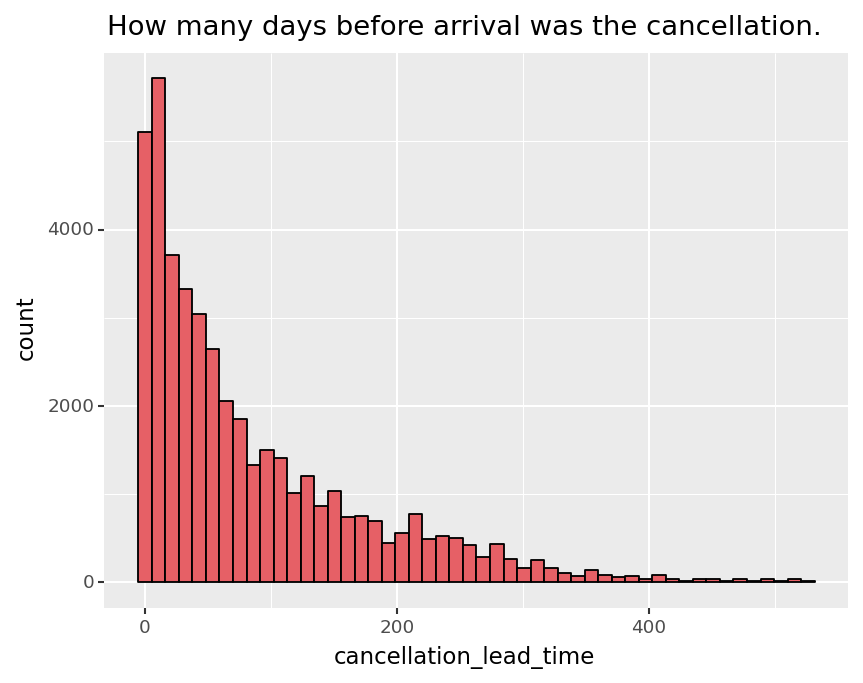

<ggplot: (685322307)>

In [9]:
p = (
    ggplot(df, aes('cancellation_lead_time')) +
    geom_histogram(bins=50, fill="#e66066", color='black') +
    ggtitle('How many days before arrival was the cancellation.')
)
p.save(f'{plots_folder}/cancellation_lead_time_histogram.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/cancellation_ratio_for_each_room_type.png


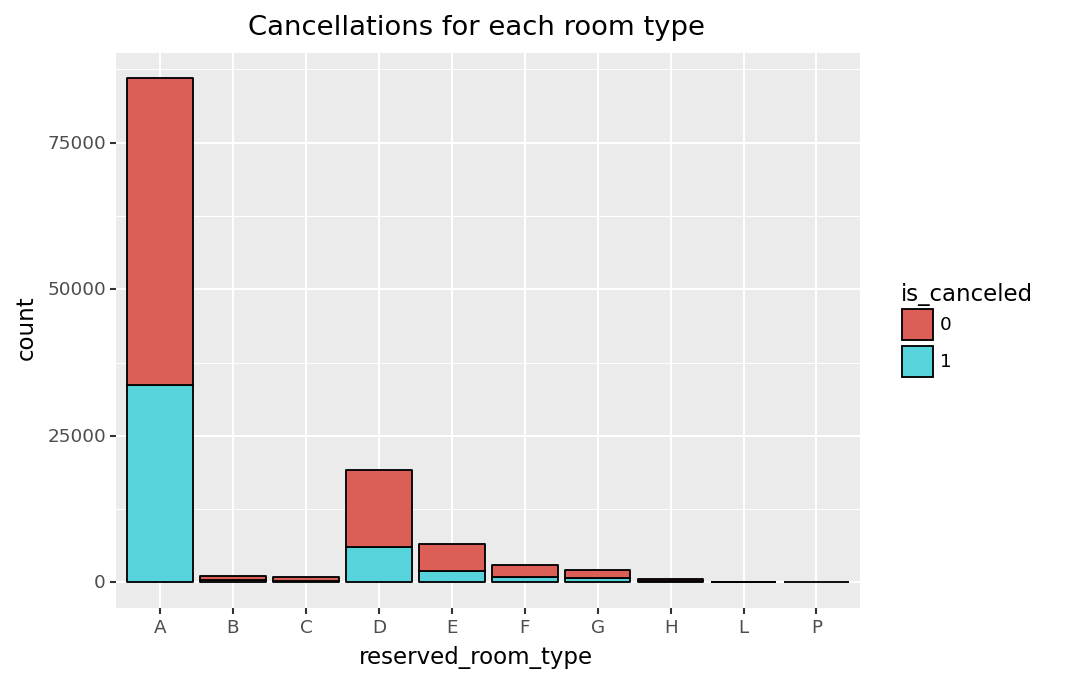

<ggplot: (685304718)>

In [61]:
p = (
    ggplot(df, aes('reserved_room_type')) +
    geom_bar(aes(fill='is_canceled'), color='black') +
    ggtitle('Cancellations for each room type')
)
p.save(f'{plots_folder}/cancellation_ratio_for_each_room_type.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/price_for_each_room_type.png
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 4 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 4 rows containing non-finite values.


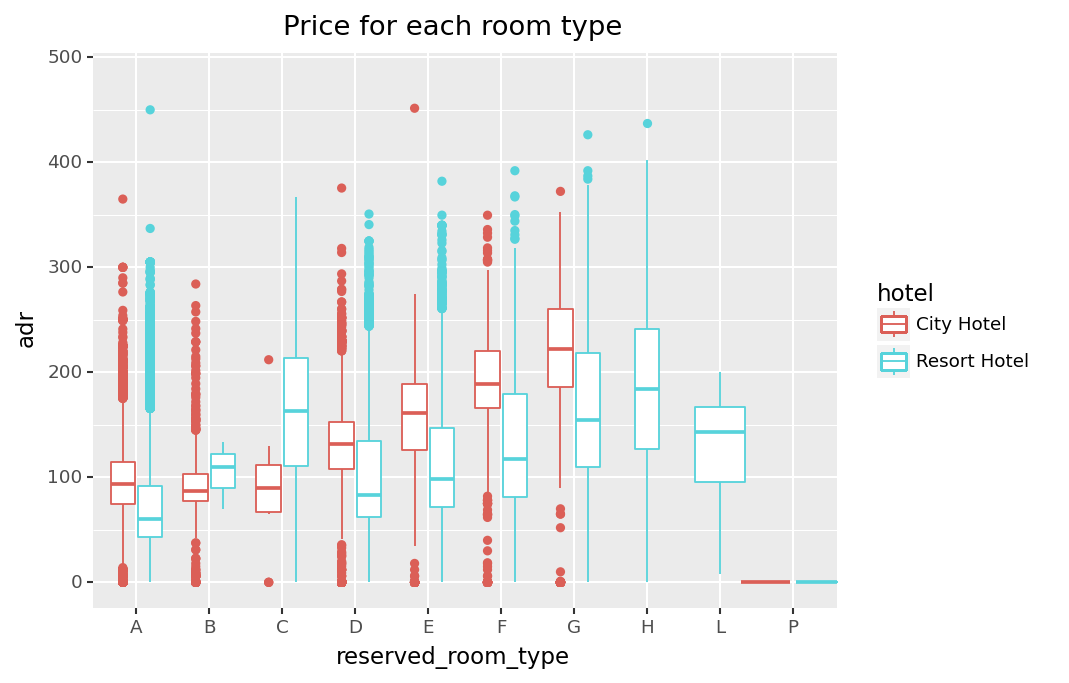

<ggplot: (723209544)>

In [70]:
p = (
    ggplot(df, aes('reserved_room_type', 'adr')) +
    p9.geom_boxplot(aes(color='hotel')) +
    p9.ylim(0, 480) +
    ggtitle('Price for each room type')
)
p.save(f'{plots_folder}/price_for_each_room_type.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/price_for_each_room_type_faceted.png
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 4 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 4 rows containing non-finite values.


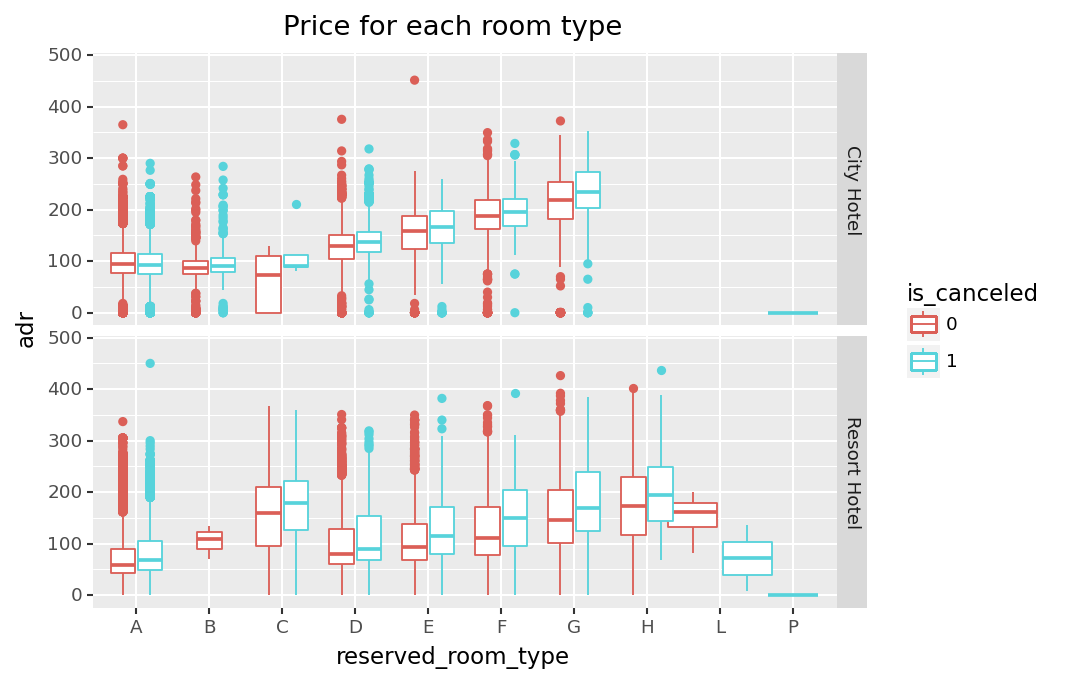

<ggplot: (704733260)>

In [71]:
p = (
    ggplot(df, aes('reserved_room_type', 'adr')) +
    p9.geom_boxplot(aes(color='is_canceled')) +
    p9.ylim(0, 480) +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Price for each room type')
)
p.save(f'{plots_folder}/price_for_each_room_type_faceted.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/jitter_for_room_type_and_price.png
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_jitter : Removed 966 rows containing missing values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_jitter : Removed 985 rows containing missing values.


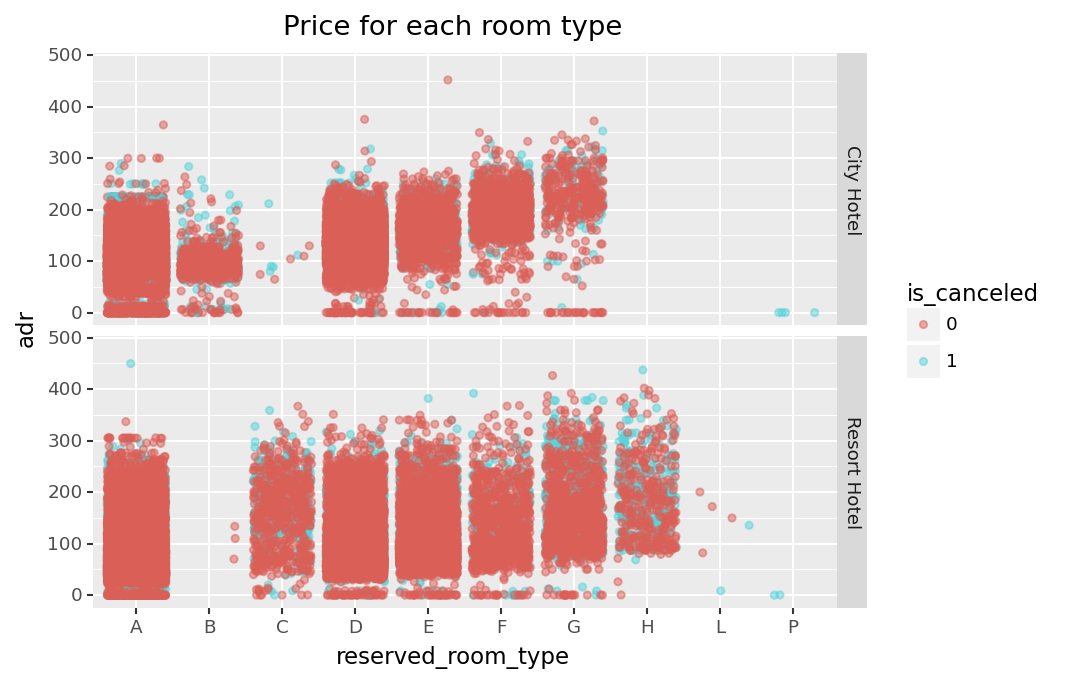

<ggplot: (753947937)>

In [72]:
p = (
    ggplot(df, aes('reserved_room_type', 'adr')) +
    p9.geom_jitter(aes(color='is_canceled'), alpha=0.5) +
    p9.ylim(0, 480) +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Price for each room type')
)
p.save(f'{plots_folder}/jitter_for_room_type_and_price.png', dpi=450, width=8, height=6)
p

In [11]:
# Let's try to estimate the capacity of the hotel
from siuba import full_join

check_ins = (
    df >>
    filter(_.is_canceled == 0) >>
    group_by(_.arrival_date, _.hotel) >>
    summarize(
        number_of_adult_check_ins = _.adults.sum(),
        number_of_children_check_ins = _.children.sum(),
        daily_rate_median = _.adr.median()
    ) >>
    rename(date = _.arrival_date)
)

check_outs = (
    df >>
    filter(_.is_canceled == 0) >>
    group_by(_.departure_date, _.hotel) >>
    summarize(
        number_of_adult_check_outs = _.adults.sum(),
        number_of_children_check_outs = _.children.sum()
    ) >>
    rename(date = _.departure_date)
)

# Note: this is cancellations FOR at given day not AT a given day.
cancellations = (
    df >>
    filter(_.is_canceled == 1) >>
    group_by(_.arrival_date, _.hotel) >>
    summarize(
        number_of_adult_cancellations = _.adults.sum(),
        number_of_children_cancellations = _.children.sum()
    ) >>
    rename(date = _.arrival_date)
)

#print(check_ins)
#print(check_outs)

combined = (
    check_ins >>
    full_join(_, check_outs, {'date': 'date', 'hotel': 'hotel'}) >>
    full_join(_, cancellations, {'date': 'date', 'hotel': 'hotel'})

)

combined.fillna(0, inplace=True)

#print(combined)

number_of_people_in_hotel = (
    combined >>
    mutate(change_in_number_of_adults = _.number_of_adult_check_ins - _.number_of_adult_check_outs) >>
    mutate(change_in_number_of_children = _.number_of_children_check_ins - _.number_of_children_check_outs) >>
    group_by(_.hotel) >>
    mutate(number_of_adults_in_hotel = _.change_in_number_of_adults.cumsum()) >>
    mutate(number_of_children_in_hotel = _.change_in_number_of_children.cumsum()) >>
    ungroup() >>
    mutate(number_of_people_in_hotel = _.number_of_adults_in_hotel + _.number_of_children_in_hotel) >>
    mutate(number_of_total_cancellations = _.number_of_adult_cancellations + _.number_of_children_cancellations) >>
    mutate(datetime = call(pd.to_datetime, _.date))
)

#print(number_of_people_in_hotel.head(6))
number_of_people_in_hotel.glimpse()

DataFrame with 1605 rows and 16 columns.
date                              <object>          2015-07-01, 2015-07-01, 2015-07-02, 2015-07-02, 2015-07-03, 2015 ...
hotel                             <object>          'City Hotel', 'Resort Hotel', 'City Hotel', 'Resort Hotel', 'Cit ...
number_of_adult_check_ins         <float64>         116.0, 70.0, 1.0, 70.0, 18.0, 56.0, 16.0, 73.0, 72.0, 2.0, 79.0, ...
number_of_children_check_ins      <float64>         0.0, 2.0, 0.0, 2.0, 0.0, 3.0, 0.0, 5.0, 8.0, 0.0, 7.0, 1.0, 8.0, ...
daily_rate_median                 <float64>         101.5, 91.1, 58.67, 98.0, 86.0, 99.3, 62.0, 94.485, 98.4, 66.13, ...
number_of_adult_check_outs        <float64>         0.0, 4.0, 0.0, 9.0, 111.0, 20.0, 0.0, 18.0, 49.0, 5.0, 37.0, 2.0 ...
number_of_children_check_outs     <float64>         0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 5.0, 0.0, 2.0, 0.0, 1.0, ...
number_of_adult_cancellations     <float64>         27.0, 10.0, 95.0, 20.0, 10.0, 28.0, 56.0, 26.0, 16.0, 56.0, 

In [12]:
# Lets calculate the capacity for each hotel
adult_capacity_resort = number_of_people_in_hotel[number_of_people_in_hotel['hotel'] == 'Resort Hotel']['number_of_adults_in_hotel'].quantile(q=0.98, interpolation='nearest')
total_capacity_resort = number_of_people_in_hotel[number_of_people_in_hotel['hotel'] == 'Resort Hotel']['number_of_people_in_hotel'].quantile(q=0.98, interpolation='nearest')
adult_capacity_city = number_of_people_in_hotel[number_of_people_in_hotel['hotel'] == 'City Hotel']['number_of_adults_in_hotel'].quantile(q=0.98, interpolation='nearest')
total_capacity_city = number_of_people_in_hotel[number_of_people_in_hotel['hotel'] == 'City Hotel']['number_of_people_in_hotel'].quantile(q=0.98, interpolation='nearest')
print(f'The hotel capacities are [adult (total)].\n* Resort:  {adult_capacity_resort} ({total_capacity_resort})\n* City:    {adult_capacity_city} ({total_capacity_city})')

The hotel capacities are [adult (total)].
* Resort:  382.0 (432.0)
* City:    654.0 (702.0)


/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/number_of_people_in_hotel.png


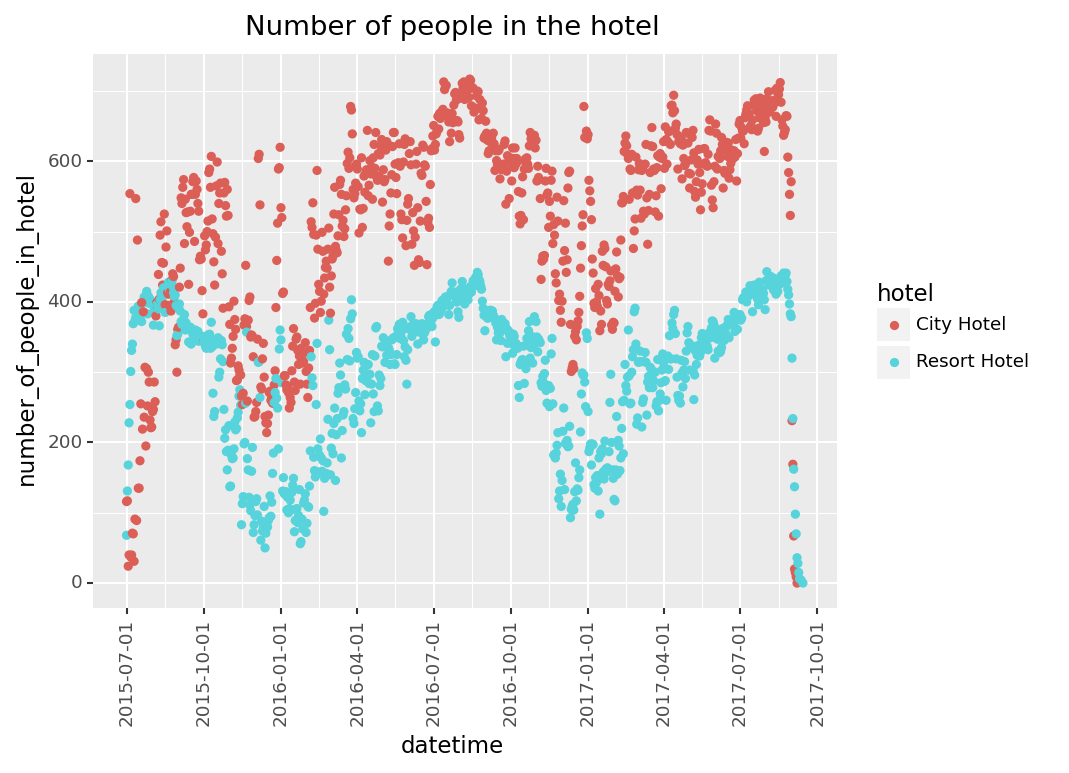

<ggplot: (685392425)>

In [13]:
# Lets plot it
p = (
    ggplot(number_of_people_in_hotel, aes(x='datetime', y='number_of_people_in_hotel', color='hotel')) +
    geom_point() +
    ggtitle('Number of people in the hotel') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/number_of_people_in_hotel.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/number_of_people_with_children.png


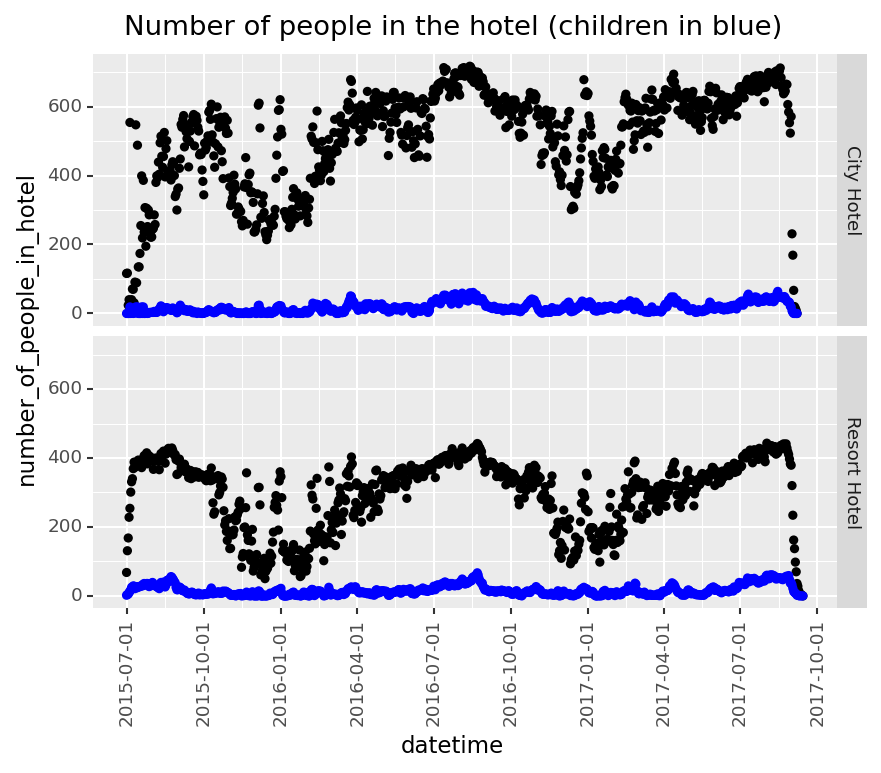

<ggplot: (685498432)>

In [14]:
p = (
    ggplot(number_of_people_in_hotel, aes(x='datetime', y='number_of_people_in_hotel')) +
    geom_point() +
    geom_point(aes(y='number_of_children_in_hotel'), color='blue') +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Number of people in the hotel (children in blue)') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/number_of_people_with_children.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/number_of_people_with_adults.png


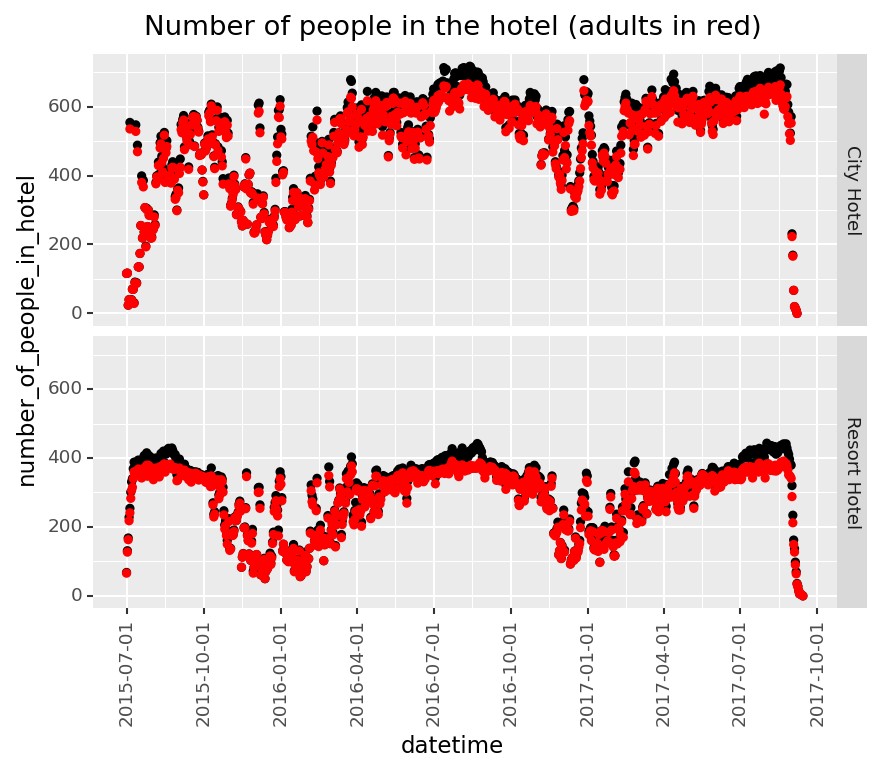

<ggplot: (685402977)>

In [15]:
# Lets plot it
p = (
    ggplot(number_of_people_in_hotel, aes(x='datetime', y='number_of_people_in_hotel')) +
    geom_point() +
    geom_point(aes(y='number_of_adults_in_hotel'), color='red') +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Number of people in the hotel (adults in red)') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/number_of_people_with_adults.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/number_of_people_with_adr.png


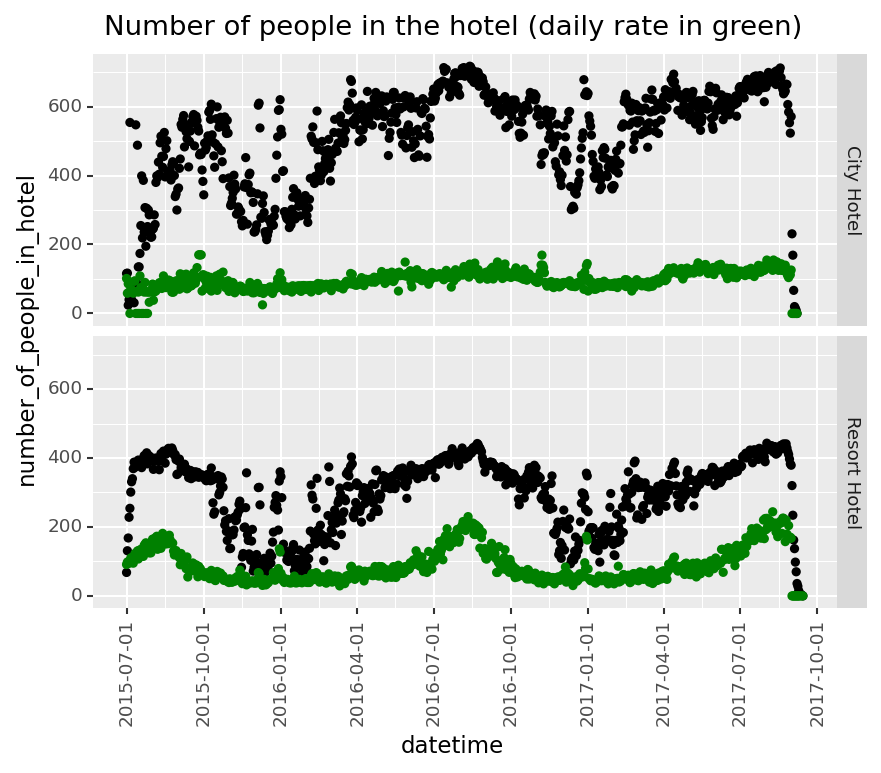

<ggplot: (685392488)>

In [16]:
# Lets plot it
p = (
    ggplot(number_of_people_in_hotel, aes(x='datetime', y='number_of_people_in_hotel')) +
    geom_point() +
    geom_point(aes(y='daily_rate_median'), color='green') +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Number of people in the hotel (daily rate in green)') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/number_of_people_with_adr.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/number_of_people_with_cancellations.png


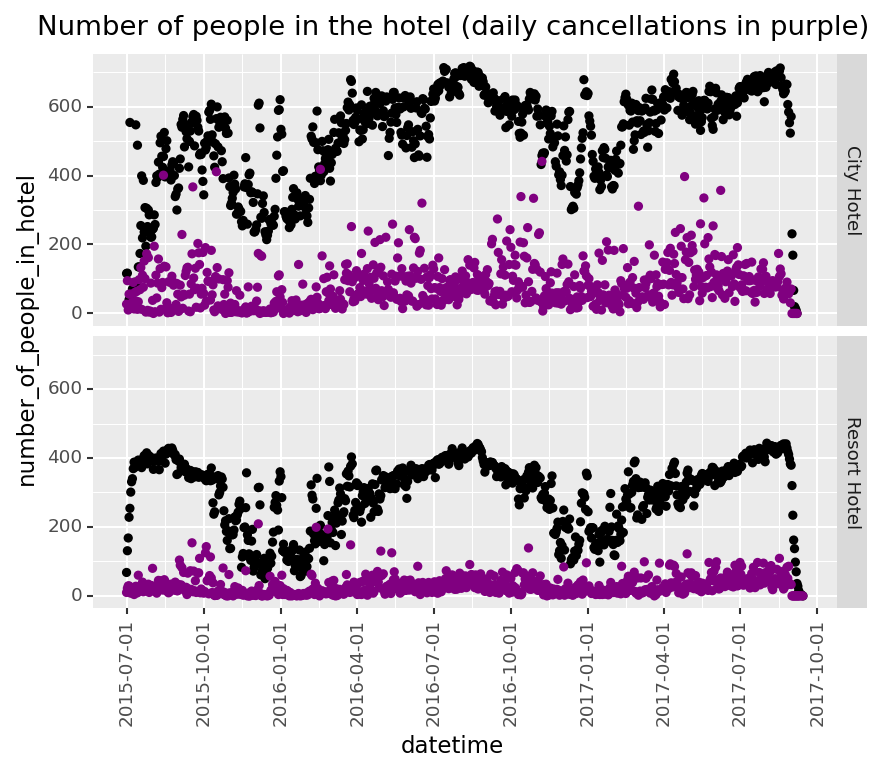

<ggplot: (689053558)>

In [17]:
# Lets plot it
p = (
    ggplot(number_of_people_in_hotel, aes(x='datetime')) +
    geom_point(aes(y='number_of_people_in_hotel')) +
    geom_point(aes(y='number_of_total_cancellations'), color='purple') +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Number of people in the hotel (daily cancellations in purple)') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/number_of_people_with_cancellations.png', dpi=450, width=8, height=6)
p

In [18]:
# Lets add the new columns to the original data
from siuba import right_join

df = (
    number_of_people_in_hotel >>
    select(
        _.date,
        _.hotel,
        _.number_of_adults_in_hotel,
        _.number_of_children_in_hotel,
        _.number_of_people_in_hotel,
        _.number_of_total_cancellations
    ) >>
    right_join(_, df, {'date': 'arrival_date', 'hotel': 'hotel'}) >>
    select(~ _.date) >>
    mutate(adult_capacity = case_when({
        _.hotel == 'Resort Hotel': adult_capacity_resort,
        _.hotel == 'City Hotel': adult_capacity_city,
        True: np.nan
    })) >>
    mutate(total_capacity = case_when({
        _.hotel == 'Resort Hotel': total_capacity_resort,
        _.hotel == 'City Hotel': total_capacity_city,
        True: np.nan
    })) >>
    mutate(booked_adults_ratio = _.number_of_adults_in_hotel / _.adult_capacity) >>
    mutate(booked_people_ratio = _.number_of_people_in_hotel / _.total_capacity)
)
df.glimpse(isna=True)

DataFrame with 119390 rows and 48 columns.
Column                          Dtype           Null         Values                                                     
------                          -----           ----         ------                                                     
hotel                           object          0 null       'Resort Hotel', 'Resort Hotel', 'Resort Hotel', 'Resort ...
number_of_adults_in_hotel       float64         0 null       66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 6 ...
number_of_children_in_hotel     float64         0 null       2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,  ...
number_of_people_in_hotel       float64         0 null       68.0, 68.0, 68.0, 68.0, 68.0, 68.0, 68.0, 68.0, 68.0, 6 ...
number_of_total_cancellations   float64         0 null       10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1 ...
is_canceled                     category        0 null       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0

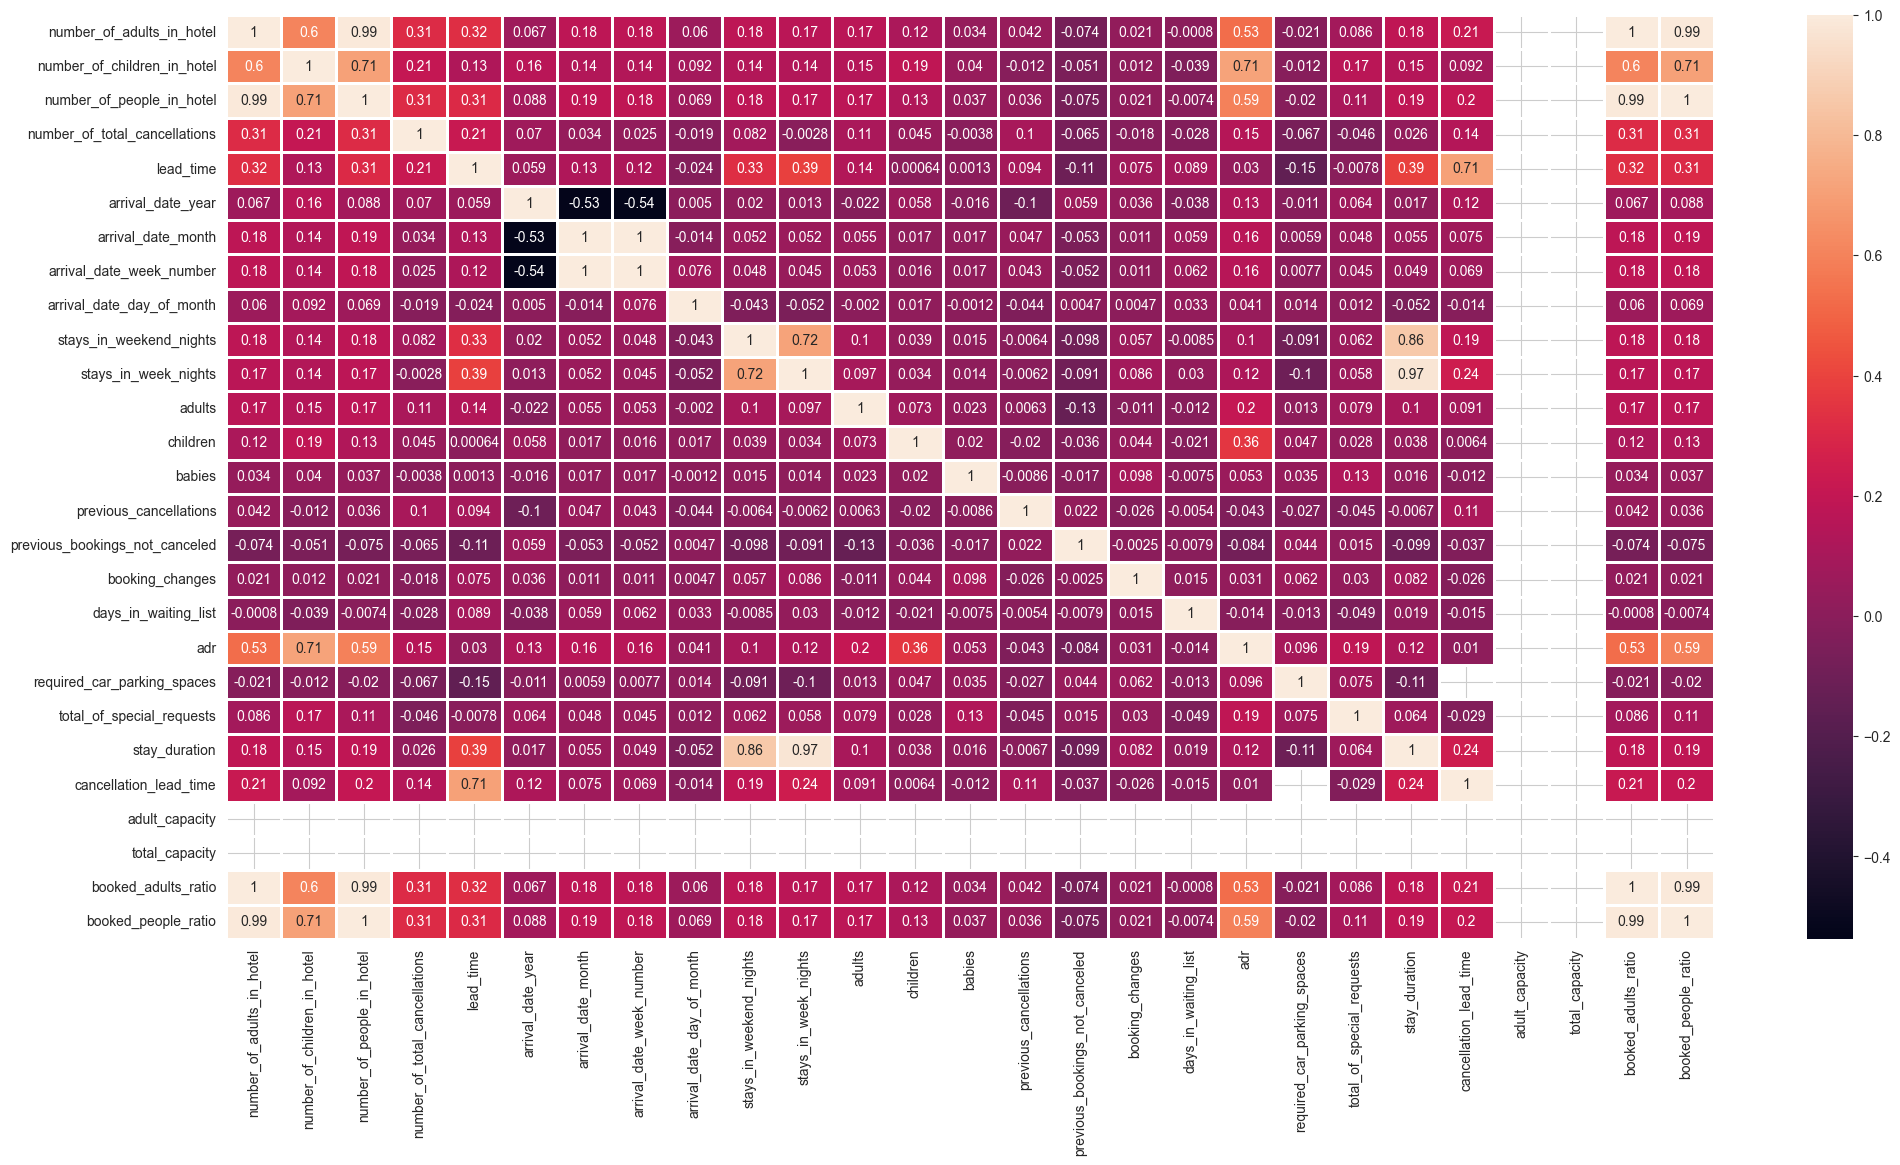

For the Resort Hotel there is a very strong correlation between number_of_children in the hotel and the price :)
Its probably more usefuly to notice, that people who make special request are significantly less likely to cancel.
Other strong predictors seem to be previous cancellations and lead time (both make you more likely to cancel)


In [19]:
# lets do a correlation heat map, and see if anything looks unexpected
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (24, 12))
resort_corr = df[df['hotel'] == 'Resort Hotel'].select_dtypes(include=np.number).corr()
sns.heatmap(resort_corr, annot=True, linewidths=1)
plt.show()

print('For the Resort Hotel there is a very strong correlation between number_of_children in the hotel and the price :)')
print('Its probably more usefuly to notice, that people who make special request are significantly less likely to cancel.')
print('Other strong predictors seem to be previous cancellations and lead time (both make you more likely to cancel)')

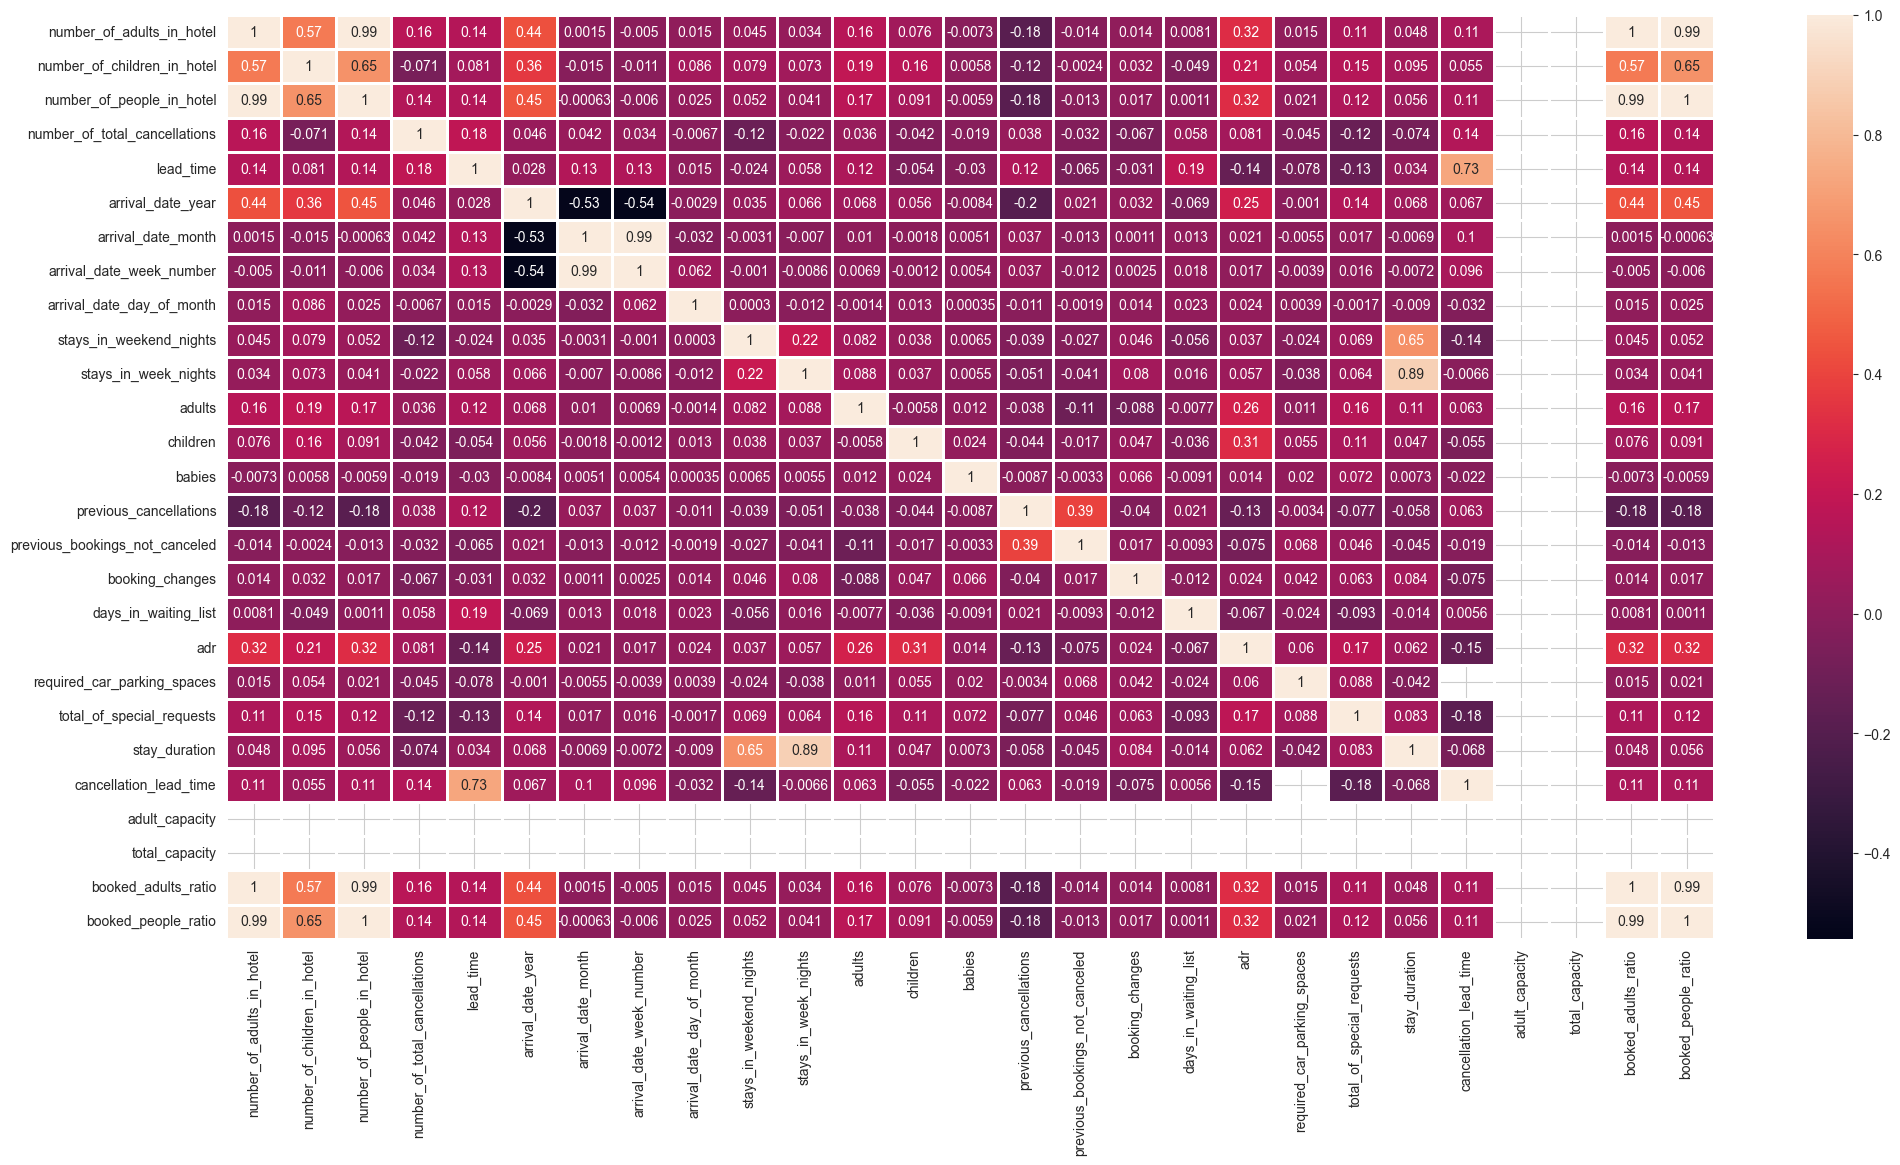

We see the same patterns as with Resort Hotel (apart from the number of children and price correlation).


In [20]:

plt.figure(figsize = (24, 12))
resort_corr = df[df['hotel'] == 'City Hotel'].select_dtypes(include=np.number).corr()
sns.heatmap(resort_corr, annot=True, linewidths=1)
plt.show()

print('We see the same patterns as with Resort Hotel (apart from the number of children and price correlation).')

# Data Prep

In [21]:
# Lets remove a few of the columns that doesn't belong in our training/testing set when trying to predict
# Note: We remove the 'booked-X-ratio', 'number-of-..' columns as they contain information not available at prediction time.
df = df.reindex(sorted(df.columns), axis=1)
df_model = (
    df >>
    select(- _.adult_capacity) >>
    select(- _.arrival_date) >>
    select(- _.arrival_date_month_name) >>
    select(- _.arrival_datetime) >>
    select(- _.booked_adults_ratio) >>
    select(- _.booked_people_ratio) >>
    select(- _.cancellation_date) >>
    select(- _.cancellation_datetime) >>
    select(- _.cancellation_lead_time) >>
    select(- _.departure_date) >>
    select(- _.number_of_adults_in_hotel) >>
    select(- _.number_of_children_in_hotel) >>
    select(- _.number_of_people_in_hotel) >>
    select(- _.number_of_total_cancellations) >>
    select(- _.reservation_status) >>
    select(- _.reservation_status_date) >>
    select(- _.total_capacity)
)

df_model['is_canceled'] = df_model['is_canceled'].astype('int')
df_model['is_repeated_guest'] = df_model['is_repeated_guest'].astype('int')

df_model.glimpse(isna=True, nunique=True)

DataFrame with 119390 rows and 31 columns.
Column                          Dtype    Null         N-unique     Values                                               
------                          -----    ----         --------     ------                                               
adr                             float64  0 null       8879 unique  0.0, 0.0, 75.0, 75.0, 98.0, 98.0, 107.0, 103.0, 8 ...
adults                          int64    0 null       14 unique    2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2 ...
agent                           object   16340 null   333 unique   nan, nan, nan, '304', '240', '240', nan, '303', ' ...
arrival_date_day_of_month       int64    0 null       31 unique    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ...
arrival_date_month              int64    0 null       12 unique    7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7 ...
arrival_date_week_number        int64    0 null       53 unique    27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,

In [22]:
# What are the categorical columns?
df_model.select_dtypes(exclude=np.number).columns

Index(['agent', 'assigned_room_type', 'company', 'country', 'customer_type', 'deposit_type', 'distribution_channel',
       'hotel', 'market_segment', 'meal', 'reserved_room_type'],
      dtype='object')

In [23]:
# Lets convert to dummy variables
df_dummy = pd.get_dummies(df_model, columns=df_model.select_dtypes(exclude=np.number).columns)
df_dummy.glimpse(isna=True, nunique=True)

# Note: Including agent, company, and country has made it blow up quite a lot.

DataFrame with 119390 rows and 931 columns.
Column                          Dtype    Null    N-unique     Values                                                    
------                          -----    ----    --------     ------                                                    
adr                             float64  0 null  8879 unique  0.0, 0.0, 75.0, 75.0, 98.0, 98.0, 107.0, 103.0, 82.0,  ...
adults                          int64    0 null  14 unique    2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  ...
arrival_date_day_of_month       int64    0 null  31 unique    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  ...
arrival_date_month              int64    0 null  12 unique    7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,  ...
arrival_date_week_number        int64    0 null  53 unique    27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27 ...
arrival_date_year               int64    0 null  3 unique     2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,

In [24]:
df_dummy_small = (
    df_dummy >>
    select(- _.startswith('agent')) >>
    select(- _.startswith('country')) >>
    select(- _.startswith('company')) >>
    select(- _.startswith('assigned_room'))
)
df_dummy_small.glimpse(isna=True, nunique=True)

DataFrame with 119390 rows and 57 columns.
Column                          Dtype    Null    N-unique     Values                                                    
------                          -----    ----    --------     ------                                                    
adr                             float64  0 null  8879 unique  0.0, 0.0, 75.0, 75.0, 98.0, 98.0, 107.0, 103.0, 82.0,  ...
adults                          int64    0 null  14 unique    2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  ...
arrival_date_day_of_month       int64    0 null  31 unique    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  ...
arrival_date_month              int64    0 null  12 unique    7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,  ...
arrival_date_week_number        int64    0 null  53 unique    27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27 ...
arrival_date_year               int64    0 null  3 unique     2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 

# Modeling

In [25]:
# First we split data into train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_dummy, test_size = 0.25, stratify=df_dummy['is_canceled'])
print(f'Number of train examples: {len(train)} out of {len(df)}.')
print(f'Number of test examples: {len(test)} out of {len(df)}.')

X_train = (
    train >>
    select(- _.is_canceled)
).fillna(0)

y_train = (
    train >>
    select(_.is_canceled)
)

X_test = (
    test >>
    select(- _.is_canceled)
).fillna(0)

y_test = (
    test >>
    select(_.is_canceled)
)

Number of train examples: 89542 out of 119390.
Number of test examples: 29848 out of 119390.


In [26]:
# Lets train a decision tree
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [27]:
y_pred = clf.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

tree_accuracy = accuracy_score(y_test, y_pred)
tree_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Our tree model has an accuracy of {tree_accuracy} and a balanced accuracy of {tree_balanced_accuracy}')
print(f'Full report:\n{classification_report(y_test, y_pred)}')

Our tree model has an accuracy of 0.8602921468775128 and a balanced accuracy of 0.8523539399097686
Full report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     18792
           1       0.81      0.82      0.81     11056

    accuracy                           0.86     29848
   macro avg       0.85      0.85      0.85     29848
weighted avg       0.86      0.86      0.86     29848



Number of train examples: 89542 out of 119390.
Number of test examples: 29848 out of 119390.
Our tree model has an accuracy of 0.8240083087644063 and a balanced accuracy of 0.8116234492431118
Full report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     18792
           1       0.76      0.76      0.76     11056

    accuracy                           0.82     29848
   macro avg       0.81      0.81      0.81     29848
weighted avg       0.82      0.82      0.82     29848



/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/decision_tree_importance.png


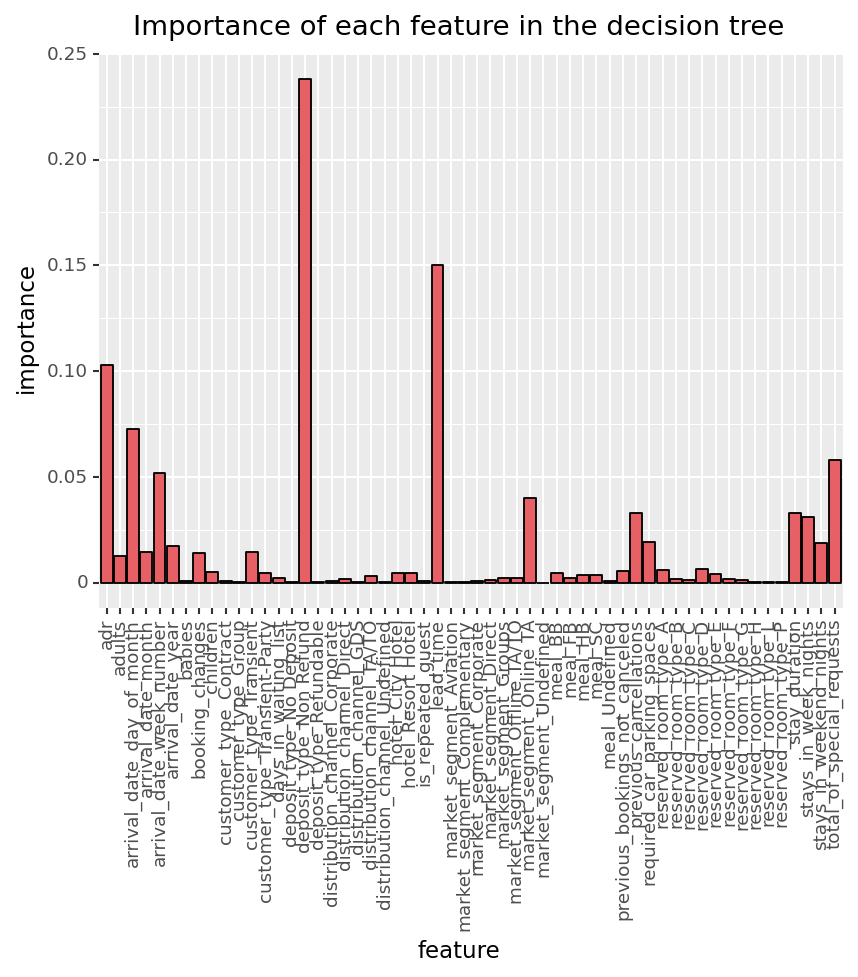

<ggplot: (689299817)>

In [29]:
# Lets do the same (but for dummy_small), then we can have a look at the importance of each feature
train_small, test_small = train_test_split(df_dummy_small, test_size = 0.25, stratify=df_dummy_small['is_canceled'])
print(f'Number of train examples: {len(train_small)} out of {len(df_dummy_small)}.')
print(f'Number of test examples: {len(test_small)} out of {len(df_dummy_small)}.')

X_train_small = (
    train_small >>
    select(- _.is_canceled)
).fillna(0)

y_train_small = (
    train_small >>
    select(_.is_canceled)
)

X_test_small = (
    test_small >>
    select(- _.is_canceled)
).fillna(0)

y_test_small = (
    test_small >>
    select(_.is_canceled)
)

clf_small = tree.DecisionTreeClassifier()
clf_small = clf_small.fit(X_train_small, y_train_small)
y_pred_small = clf_small.predict(X_test_small)


tree_accuracy = accuracy_score(y_test_small, y_pred_small)
tree_balanced_accuracy = balanced_accuracy_score(y_test_small, y_pred_small)
print(f'Our tree model has an accuracy of {tree_accuracy} and a balanced accuracy of {tree_balanced_accuracy}')
print(f'Full report:\n{classification_report(y_test_small, y_pred_small)}')


# Let's have a look at the feature importance of our decision tree
tree_feature_importance = clf_small.feature_importances_
#print(tree_feature_importance)

importance_data = pd.DataFrame({'feature': X_train_small.columns, 'importance': tree_feature_importance})

p = (
    ggplot(importance_data, aes(x='feature', y='importance')) +
    geom_col(fill='#e66066', color='black') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5)) +
    ggtitle('Importance of each feature in the decision tree')
)
p.save(f'{plots_folder}/decision_tree_importance.png', dpi=450, width=14, height=6)
p

In [30]:
"""
# Lets train an SGD model (Stochastic Gradiant Descent)
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf = clf.fit(X_train, y_train)
"""

'\n# Lets train an SGD model (Stochastic Gradiant Descent)\nfrom sklearn.linear_model import SGDClassifier\nclf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)\nclf = clf.fit(X_train, y_train)\n'

In [31]:
"""
y_pred = clf.predict(X_test)
"""

'\ny_pred = clf.predict(X_test)\n'

In [32]:
"""
sgd_accuracy = accuracy_score(y_test, y_pred)
sgd_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Our tree model has an accuracy of {sgd_accuracy} and a balanced accuracy of {sgd_balanced_accuracy}')
print(f'Full report:\n{classification_report(y_test, y_pred)}')
"""

"\nsgd_accuracy = accuracy_score(y_test, y_pred)\nsgd_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)\nprint(f'Our tree model has an accuracy of {sgd_accuracy} and a balanced accuracy of {sgd_balanced_accuracy}')\nprint(f'Full report:\n{classification_report(y_test, y_pred)}')\n"

# Optimizing with the model?

In [33]:
# todo: make model probabilistic
# todo: apply model to entire dataset and create new column 'will_be_cancelled'
# todo: use 'will_be_cancelled' to calculate 'expected_number_of_people' (Can we limit this to lead_time > 7?)
# NOTE/DISCLAIMER: A lot of cheating is happening because the data we are training on already knows if the booking was cancelled, and then reapplying it. Even if we split out test/train by dates (say test=2017), then its likely that information would still leak.

In [34]:
X_all = (
    df_dummy >>
    select(- _.is_canceled)
).fillna(0)


y_all = (
    df_dummy >>
    select(_.is_canceled)
).fillna(0)

y_pred = clf.predict(X_all)

# lets verify that our accuracy is really high when we predict on the traning set too :D
print(f'Full report:\n{classification_report(y_all, y_pred)}')

Full report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     75166
           1       0.95      0.95      0.95     44224

    accuracy                           0.96    119390
   macro avg       0.96      0.96      0.96    119390
weighted avg       0.96      0.96      0.96    119390



In [35]:
df['predicted_to_be_canceled'] = y_pred
df.glimpse_unique()

DataFrame with 119390 rows and 49 columns.
adr                             <float64>         0.0, 75.0, 98.0, 107.0, 103.0, 82.0, 105.5, 123.0, 145.0, 97.0, 15 ...
adult_capacity                  <float64>         382.0, 654.0                                                          
adults                          <int64>           2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10                       
agent                           <object>          nan, '304', '240', '303', '15', '241', '8', '250', '115', '5', '17 ...
arrival_date                    <object>          2015-07-01, 2015-07-02, 2015-07-03, 2015-07-04, 2015-07-05, 2015-0 ...
arrival_date_day_of_month       <int64>           1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...
arrival_date_month              <int64>           7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6                                 
arrival_date_month_name         <object>          'July', 'August', 'September', 'October', 'November', 'Decem

In [36]:
from siuba import left_join

# lets calculate expected number of people
expected_check_ins = (
    df >>
    mutate(expected_adults = (1 - _.predicted_to_be_canceled) * _.adults) >>
    mutate(expected_children = (1 - _.predicted_to_be_canceled) * _.children) >>
    # mutate(expected_babies = (1 - _.predicted_to_be_canceled) * _.babies) >>
    group_by(_.arrival_date, _.hotel) >>
    summarize(
        expected_number_of_adult_check_ins = _.expected_adults.sum(),
        expected_number_of_children_check_ins = _.expected_children.sum()
    ) >>
    rename(date = _.arrival_date)
)
print(expected_check_ins)


expected_check_outs = (
    df >>
    mutate(expected_adults = (1 - _.predicted_to_be_canceled) * _.adults) >>
    mutate(expected_children = (1 - _.predicted_to_be_canceled) * _.children) >>
    # mutate(expected_babies = (1 - _.predicted_to_be_canceled) * _.babies) >>
    group_by(_.departure_date, _.hotel) >>
    summarize(
        expected_number_of_adult_check_outs = _.expected_adults.sum(),
        expected_number_of_children_check_outs = _.expected_children.sum()
    ) >>
    rename(date = _.departure_date)
)

print(expected_check_outs)


expected_combined = (
    expected_check_ins >>
    full_join(_, expected_check_outs, {'date': 'date', 'hotel': 'hotel'})
)

expected_combined.fillna(0, inplace=True)

print(expected_combined)


expected_number_of_people = (
    expected_combined >>
    mutate(expected_change_in_number_of_adults = _.expected_number_of_adult_check_ins - _.expected_number_of_adult_check_outs) >>
    mutate(expected_change_in_number_of_children = _.expected_number_of_children_check_ins - _.expected_number_of_children_check_outs) >>
    group_by(_.hotel) >>
    mutate(expected_number_of_adults_in_hotel = _.expected_change_in_number_of_adults.cumsum()) >>
    mutate(expected_number_of_children_in_hotel = _.expected_change_in_number_of_children.cumsum()) >>
    ungroup() >>
    mutate(expected_number_of_people_in_hotel = _.expected_number_of_adults_in_hotel + _.expected_number_of_children_in_hotel)
)

print(expected_number_of_people.head(6))
expected_number_of_people.glimpse()







            date         hotel  expected_number_of_adult_check_ins  expected_number_of_children_check_ins
0     2015-07-01    City Hotel                                 116                                    0.0
1     2015-07-01  Resort Hotel                                  74                                    2.0
2     2015-07-02    City Hotel                                   1                                    0.0
3     2015-07-02  Resort Hotel                                  70                                    2.0
4     2015-07-03    City Hotel                                  22                                    0.0
...          ...           ...                                 ...                                    ...
1581  2017-08-29  Resort Hotel                                  43                                    2.0
1582  2017-08-30    City Hotel                                  67                                    4.0
1583  2017-08-30  Resort Hotel                

In [37]:


df2 = (
    expected_number_of_people >>
    select(
        _.date,
        _.hotel,
        _.expected_number_of_adults_in_hotel,
        _.expected_number_of_children_in_hotel,
        _.expected_number_of_people_in_hotel
    ) >>
    right_join(_, df, {'date': 'arrival_date', 'hotel': 'hotel'}) >>
    select(~ _.date) >>
    mutate(expected_booked_adults_ratio = _.expected_number_of_adults_in_hotel / _.adult_capacity) >>
    mutate(expected_booked_people_ratio = _.expected_number_of_people_in_hotel / _.total_capacity)
)

df2.glimpse(isna=True)



DataFrame with 119390 rows and 54 columns.
Column                                Dtype           Null         Values                                               
------                                -----           ----         ------                                               
hotel                                 object          0 null       'Resort Hotel', 'Resort Hotel', 'Resort Hotel', ' ...
expected_number_of_adults_in_hotel    float64         0 null       70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 7 ...
expected_number_of_children_in_hotel  float64         0 null       2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
expected_number_of_people_in_hotel    float64         0 null       72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 7 ...
adr                                   float64         0 null       0.0, 0.0, 75.0, 75.0, 98.0, 98.0, 107.0, 103.0, 8 ...
adult_capacity                        float64         0 null       382.0, 382.0, 382.0, 382.0, 382.0, 382.0, 3

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/expected-number-of-people.png


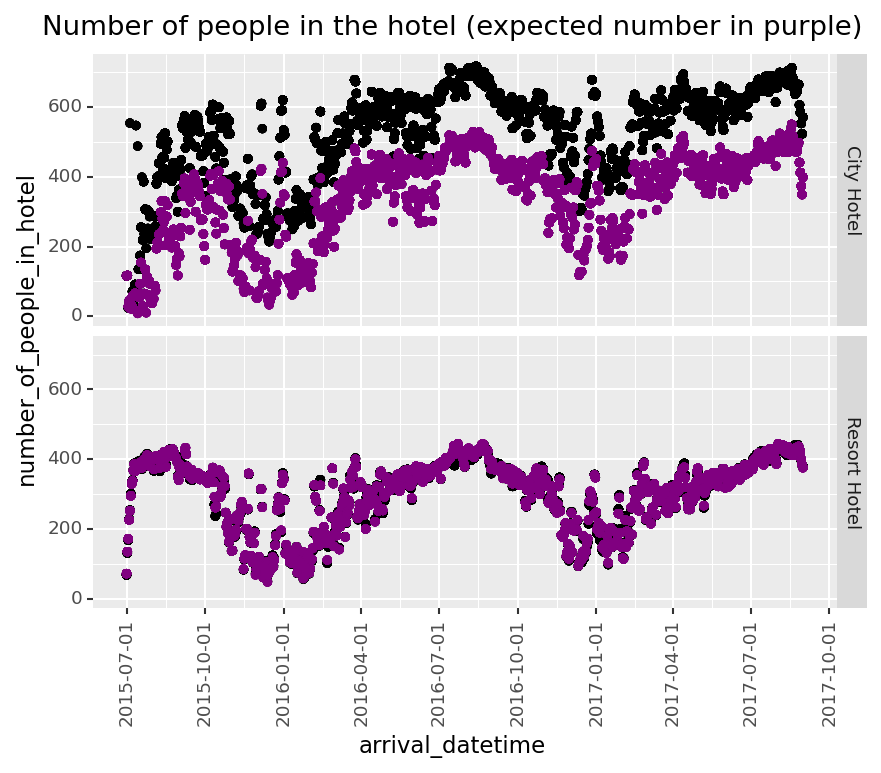

<ggplot: (685368507)>

In [38]:
# Lets plot it
p = (
    ggplot(df2, aes(x='arrival_datetime')) +
    geom_point(aes(y='number_of_people_in_hotel')) +
    geom_point(aes(y='expected_number_of_people_in_hotel'), color='purple') +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Number of people in the hotel (expected number in purple)') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/expected-number-of-people.png', dpi=450, width=8, height=6)
p

In [39]:
# Note: that doesn't look like we had hoped. The reason is (probably), that the hotel is already re-booking whenever a cancellation occurs, and we only make the prediction when the book occurs. Thus, we are not levering the signal that the booking has not been cancelled YET (because it is not in the data).

In [54]:
# What happens if we remove cancellations that happen more than 1 week in advance?

df3 = (
    df >>
    filter(~(_.cancellation_lead_time > 14))
)


expected_check_ins = (
    df3 >>
    mutate(expected_adults = (1 - _.predicted_to_be_canceled) * _.adults) >>
    mutate(expected_children = (1 - _.predicted_to_be_canceled) * _.children) >>
    # mutate(expected_babies = (1 - _.predicted_to_be_canceled) * _.babies) >>
    group_by(_.arrival_date, _.hotel) >>
    summarize(
        expected_number_of_adult_check_ins = _.expected_adults.sum(),
        expected_number_of_children_check_ins = _.expected_children.sum()
    ) >>
    rename(date = _.arrival_date)
)
print(expected_check_ins)


expected_check_outs = (
    df3 >>
    mutate(expected_adults = (1 - _.predicted_to_be_canceled) * _.adults) >>
    mutate(expected_children = (1 - _.predicted_to_be_canceled) * _.children) >>
    # mutate(expected_babies = (1 - _.predicted_to_be_canceled) * _.babies) >>
    group_by(_.departure_date, _.hotel) >>
    summarize(
        expected_number_of_adult_check_outs = _.expected_adults.sum(),
        expected_number_of_children_check_outs = _.expected_children.sum()
    ) >>
    rename(date = _.departure_date)
)

print(expected_check_outs)


expected_combined = (
    expected_check_ins >>
    full_join(_, expected_check_outs, {'date': 'date', 'hotel': 'hotel'})
)

expected_combined.fillna(0, inplace=True)

#print(expected_combined)


expected_number_of_people = (
    expected_combined >>
    mutate(expected_change_in_number_of_adults = _.expected_number_of_adult_check_ins - _.expected_number_of_adult_check_outs) >>
    mutate(expected_change_in_number_of_children = _.expected_number_of_children_check_ins - _.expected_number_of_children_check_outs) >>
    group_by(_.hotel) >>
    mutate(expected_number_of_adults_in_hotel = _.expected_change_in_number_of_adults.cumsum()) >>
    mutate(expected_number_of_children_in_hotel = _.expected_change_in_number_of_children.cumsum()) >>
    ungroup() >>
    mutate(expected_number_of_people_in_hotel = _.expected_number_of_adults_in_hotel + _.expected_number_of_children_in_hotel)
)

#print(expected_number_of_people.head(6))
#expected_number_of_people.glimpse()


df3 = (
    expected_number_of_people >>
    select(
        _.date,
        _.hotel,
        _.expected_number_of_adults_in_hotel,
        _.expected_number_of_children_in_hotel,
        _.expected_number_of_people_in_hotel
    ) >>
    right_join(_, df3, {'date': 'arrival_date', 'hotel': 'hotel'}) >>
    select(~ _.date) >>
    mutate(expected_booked_adults_ratio = _.expected_number_of_adults_in_hotel / _.adult_capacity) >>
    mutate(expected_booked_people_ratio = _.expected_number_of_people_in_hotel / _.total_capacity)
)

df3.glimpse_unique(isna=True)


            date         hotel  expected_number_of_adult_check_ins  expected_number_of_children_check_ins
0     2015-07-01    City Hotel                                 116                                    0.0
1     2015-07-01  Resort Hotel                                  70                                    2.0
2     2015-07-02    City Hotel                                   1                                    0.0
3     2015-07-02  Resort Hotel                                  70                                    2.0
4     2015-07-03    City Hotel                                  20                                    0.0
...          ...           ...                                 ...                                    ...
1581  2017-08-29  Resort Hotel                                  43                                    2.0
1582  2017-08-30    City Hotel                                  62                                    4.0
1583  2017-08-30  Resort Hotel                

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/expected-number-of-people-2-week.png


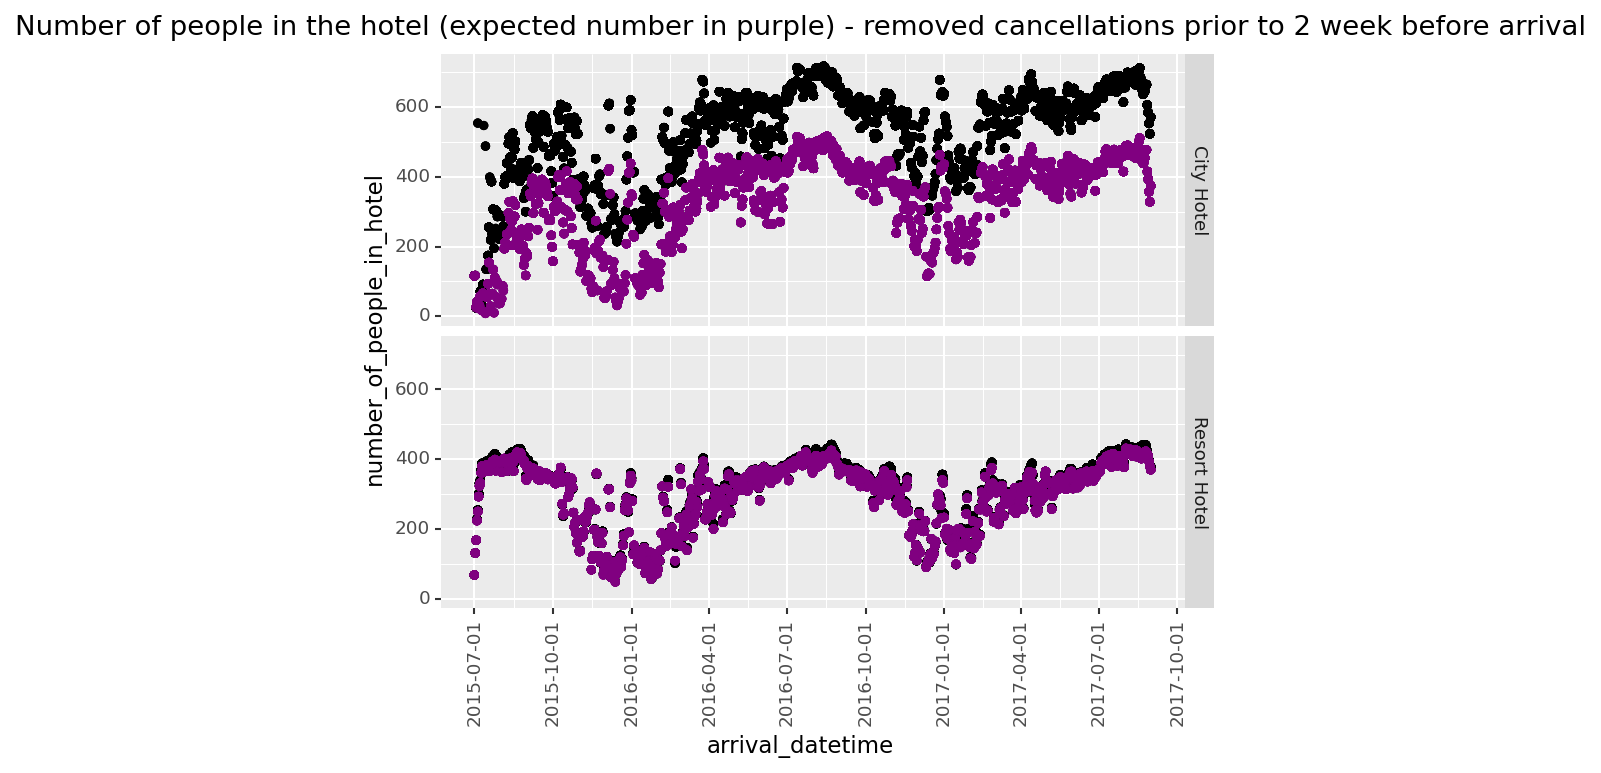

<ggplot: (721003539)>

In [55]:
# Lets plot it
p = (
    ggplot(df3, aes(x='arrival_datetime')) +
    geom_point(aes(y='number_of_people_in_hotel')) +
    geom_point(aes(y='expected_number_of_people_in_hotel'), color='purple') +
    p9.facet_grid('hotel ~ .') +
    ggtitle('Number of people in the hotel (expected number in purple) - removed cancellations prior to 2 week before arrival') +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.save(f'{plots_folder}/expected-number-of-people-2-week.png', dpi=450, width=8, height=6)
p

/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./plots/cancellation_lead_time_histogram.png
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 103682 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 103682 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/envs/hotel-booking/lib/python3.10/site-packages/plotnine/layer.py:411: 

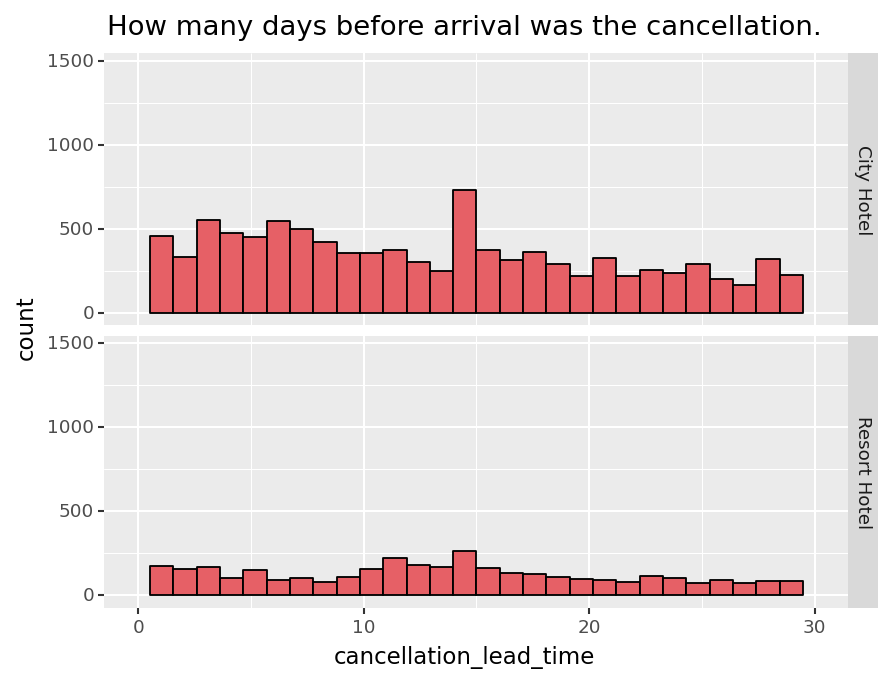

<ggplot: (680730618)>

In [53]:
# Our decision tree seem to have picked up some artifact with lead time in the City Hotel - lets ignore that for now.
# What this shows, is that we can accurately (with cheating :D) predict the capacity in the Resort Hotel, i.e. we can confidently overbook!

